In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


In [53]:
# Reading the dataset and visualize the first 5 rows
df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [54]:
#Investigate the shape of df
df.shape

(918, 12)

In [55]:
#Investigate the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [56]:
#Investigate the percentage of  the null value for each colum
round(df.isnull().sum().sort_values(ascending=False)/len(df),2)

Age               0.0
Sex               0.0
ChestPainType     0.0
RestingBP         0.0
Cholesterol       0.0
FastingBS         0.0
RestingECG        0.0
MaxHR             0.0
ExerciseAngina    0.0
Oldpeak           0.0
ST_Slope          0.0
HeartDisease      0.0
dtype: float64

In [57]:
#Checking if there is balance between the classes of the target


class_distribution = df['HeartDisease'].value_counts()
print("Class Distribution:")
print(class_distribution)

# Calculate imbalance ratio
imbalance_ratio = class_distribution.min() / class_distribution.max()
print("Imbalance Ratio:", imbalance_ratio)


Class Distribution:
HeartDisease
1    508
0    410
Name: count, dtype: int64
Imbalance Ratio: 0.8070866141732284


The imbalance ratio is approximately 0.81 which suggests some degree of class imbalance but may not be considered severely imbalanced. 

We have two types of variables:
- **Categorical Features:** The count plot displays the number of occurrences for each category. The counts are annotated above each bar for clarity.
- **Numerical Features:** The histogram provides a visual representation of the distribution, and the KDE curve helps to understand the underlying distribution pattern.


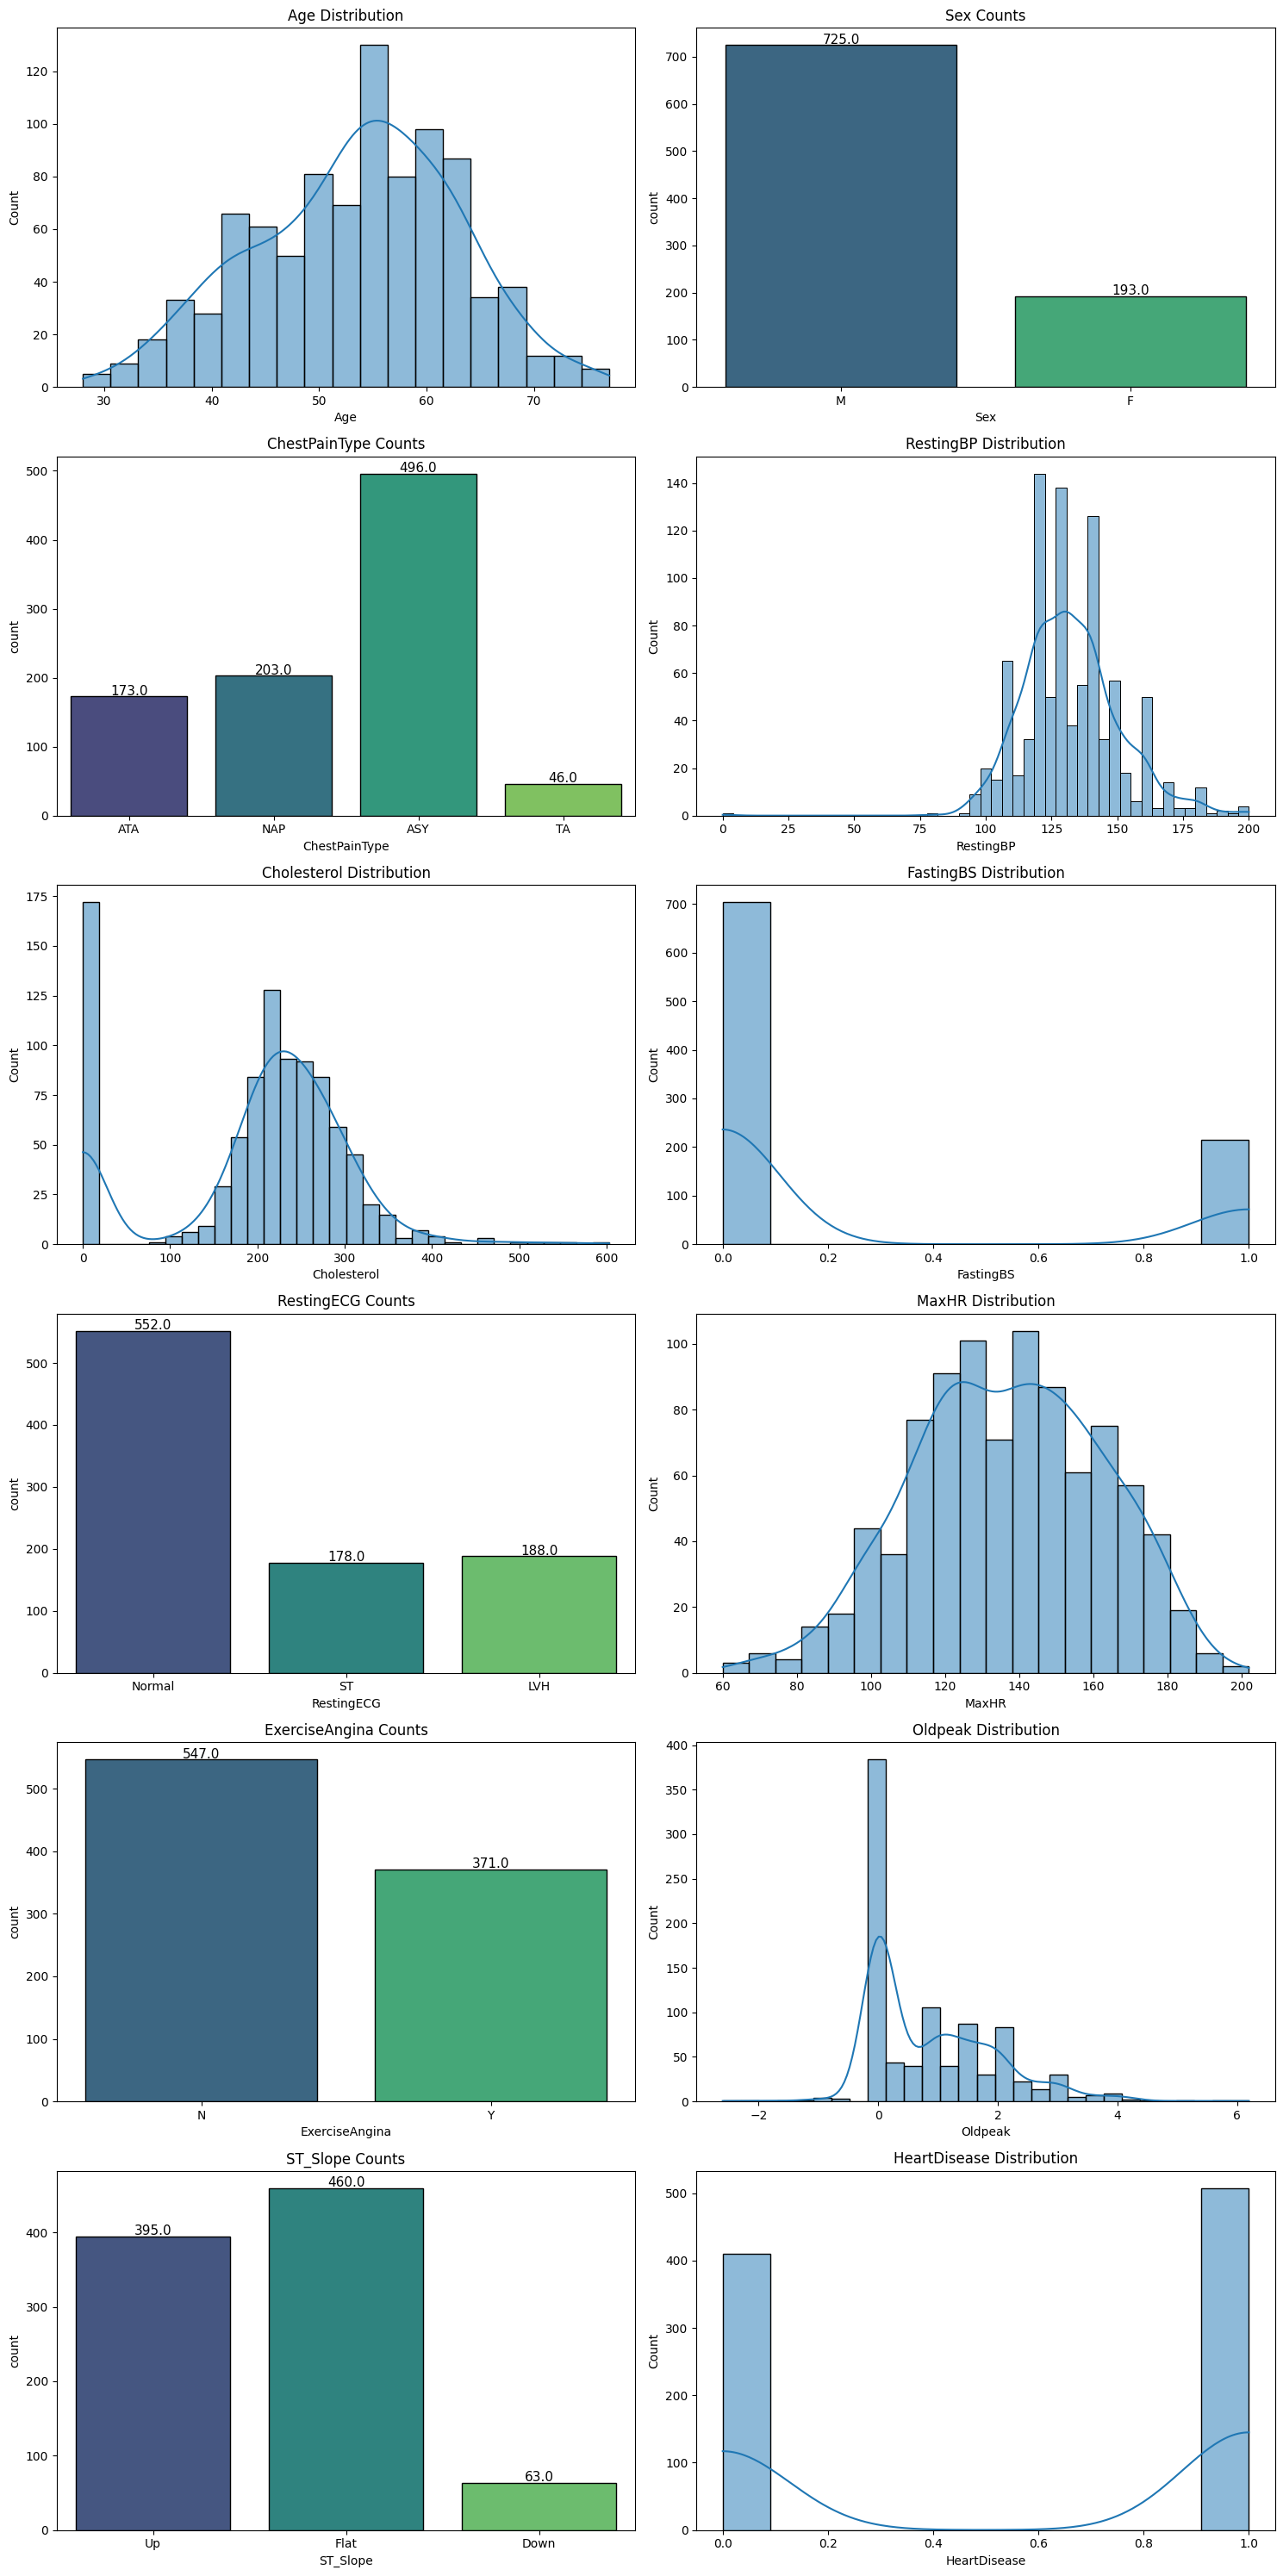

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = 2
num_rows = (len(df.columns) + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))


if num_rows == 1:
    axes = axes.reshape(1, -1)
if num_cols == 1:
    axes = axes.reshape(-1, 1)

# Iterate over each column to plot
for i, column in enumerate(df.columns):
    row_index = i // num_cols
    col_index = i % num_cols

    # Plot the appropriate visualization based on the data type of the column
    if df[column].dtype in ['int64', 'float64']:
        # Plot histogram for numerical columns
        sns.histplot(df[column], ax=axes[row_index, col_index], kde=True)
        axes[row_index, col_index].set_title(f'{column} Distribution')
    else:
        # Plot count plot for categorical columns
        sns.countplot(x=column, data=df, palette='viridis', edgecolor='black', ax=axes[row_index, col_index])
        for rect in axes[row_index, col_index].patches:
            axes[row_index, col_index].text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(),
                                             horizontalalignment='center', fontsize=11)
        axes[row_index, col_index].set_title(f'{column} Counts')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


By examining these plots, we can gain insights into the distribution and frequency of different values across the dataset's features.


- **Sex**: There is a predominance of male patients compared to female patients.
- **Age Distribution**: The age distribution appears to follow a normal distribution with a peak between 50 to 60 years of age.
- **Chest Pain Type**: We observe a predominance of asymptomatic individuals.
- **Cholesterol**: There are many zero values, which may indicate missing data as a cholesterol measurement cannot be zero. This might require some transformation.
- **Fasting Blood Sugar (FBS)**: The FBS feature is already binary encoded, where 0 represents a blood sugar level < 120 mg/dL and 1 represents > 120 mg/dL. We observe a higher count of 0.
- **Resting ECG**: There is a higher count of normal ECG results.
- **Oldpeak**: The distribution is skewed to the right, indicating that a transformation may be necessary if we need to scale the data.


### Next Steps

In the next cell, we will plot the different features related to the presence of heart disease to understand their distribution and relationships.

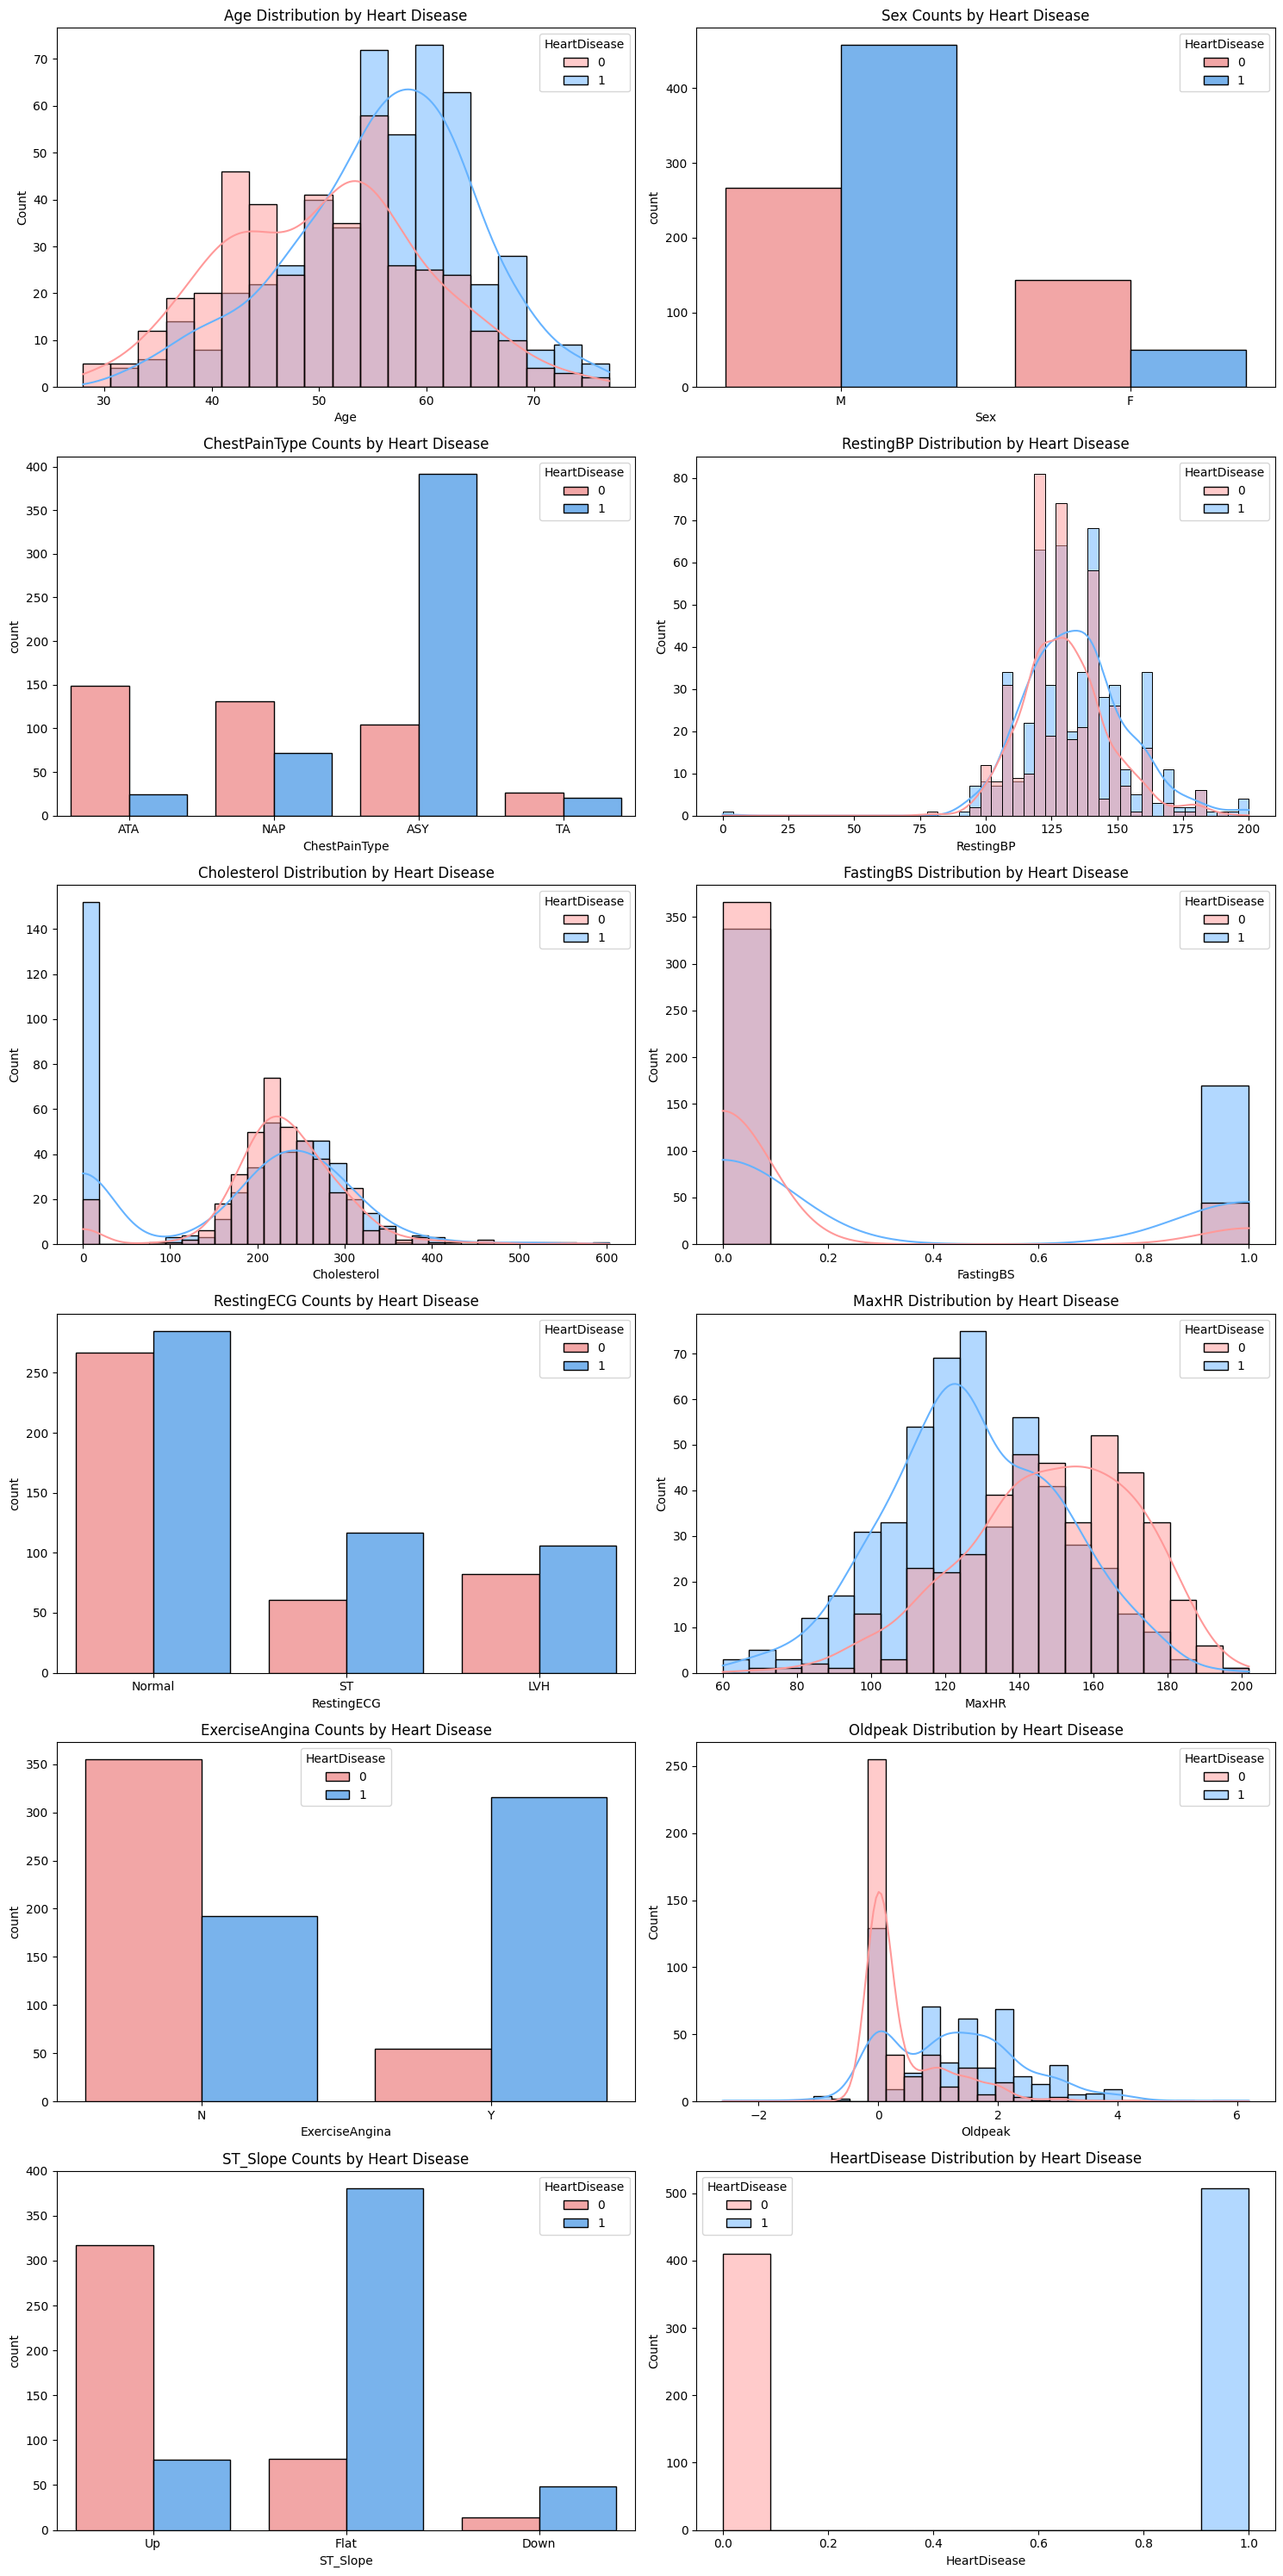

In [59]:
# Define colors for the plots
colors = ['#ff9999', '#66b3ff']

# Calculate the number of rows and columns for the grid layout
num_cols = 2  # Number of columns in the grid
num_rows = (len(df.columns) + num_cols - 1) // num_cols  # Number of rows in the grid

# Create the grid layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Iterate over each column in the DataFrame
for i, column in enumerate(df.columns):
    # Calculate the row and column index for the current subplot
    row_index = i // num_cols
    col_index = i % num_cols

    # Check if the column is numerical
    if df[column].dtype in ['int64', 'float64']:
        # Plot histogram for numerical columns
        sns.histplot(df, x=column, hue='HeartDisease', palette=colors, kde=True, alpha=0.5, ax=axes[row_index, col_index])
        axes[row_index, col_index].set_title(f'{column} Distribution by Heart Disease')

    else:
        # Plot count plot for categorical columns
        sns.countplot(x=column, hue='HeartDisease', data=df, palette=colors, edgecolor='black', ax=axes[row_index, col_index])
        axes[row_index, col_index].set_title(f'{column} Counts by Heart Disease')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


### Analysis of Features Related to Heart Disease

From the graphs, we can make the following observations about the features related to heart disease:

- **Sex**: Heart disease is more frequent in male patients than in female patients.
- **Age Distribution**: Patients above 50 years old have an increased risk of heart disease.
- **Resting Blood Pressure (BP) and Chest Pain Type**: These are not strong predictors of heart disease. A large number of patients diagnosed with heart disease report no chest pain, and resting BP values overlap significantly between patients with and without heart disease.
- **Cholesterol**: There are values of 0 for cholesterol, which cannot be accurate and need to be converted or addressed as missing data.
- **Fasting Blood Sugar (FBS)**: FBS is not a relevant predictor of heart disease, as high and low FBS values are present in both patients with and without heart disease. We might consider dropping this feature.
- **Resting ECG**: This is predominantly normal even in patients with heart disease, indicating it is not a strong predictor.
- **Exercise Induced Angina and ST Slope**: The presence of exercise-induced angina and a flat ST slope are likely good predictors of heart disease, as these features are prevalent in patients with the condition.


In [60]:
# Calculate the percentage of zero values in the 'Cholesterol' column
zero_percentage_chol = (df['Cholesterol'] == 0).mean() * 100

# Calculate the percentage of zero values in the 'Resting BP' column
zero_percentage_bp = (df['RestingBP'] == 0).mean() * 100

# Print the percentages of zero values
print(f"Percentage of zero values in the 'Cholesterol' column: {zero_percentage_chol:.2f}%")
print(f"Percentage of zero values in the 'Resting BP' column: {zero_percentage_bp:.2f}%")


Percentage of zero values in the 'Cholesterol' column: 18.74%
Percentage of zero values in the 'Resting BP' column: 0.11%


In [61]:
# Replace zero values in 'Cholesterol' with the mean
mean_chol = df['Cholesterol'][df['Cholesterol'] != 0].mean()
df['Cholesterol'] = df['Cholesterol'].replace(0, mean_chol)

# Replace zero values in 'Resting BP' with the mean
mean_bp = df['RestingBP'][df['RestingBP'] != 0].mean()
df['RestingBP'] = df['RestingBP'].replace(0, mean_bp)


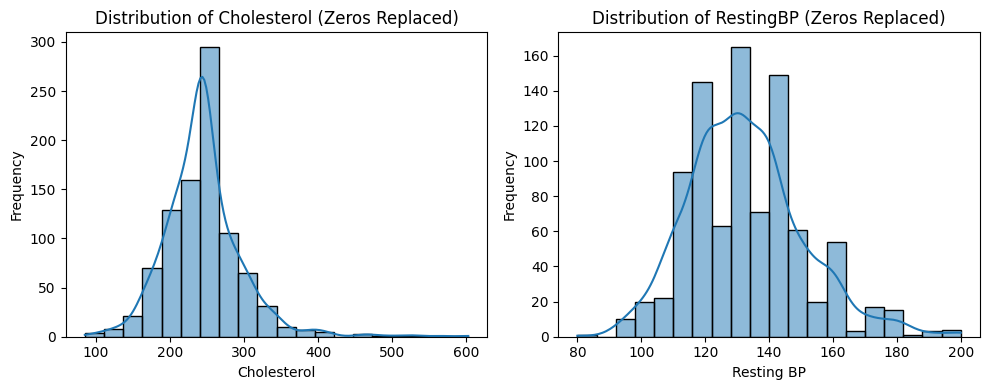

In [62]:
# Plot the distributions of 'Cholesterol' and 'Resting BP'
plt.figure(figsize=(10, 4))

# Distribution of 'Cholesterol'
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Cholesterol', bins=20, kde=True)
plt.title('Distribution of Cholesterol (Zeros Replaced)')
plt.xlabel('Cholesterol')
plt.ylabel('Frequency')

# Distribution of 'Resting BP'
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='RestingBP', bins=20, kde=True)
plt.title('Distribution of RestingBP (Zeros Replaced)')
plt.xlabel('Resting BP')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Now that we have dealt with missing values we can see that also the Cholesterol has normal distribution


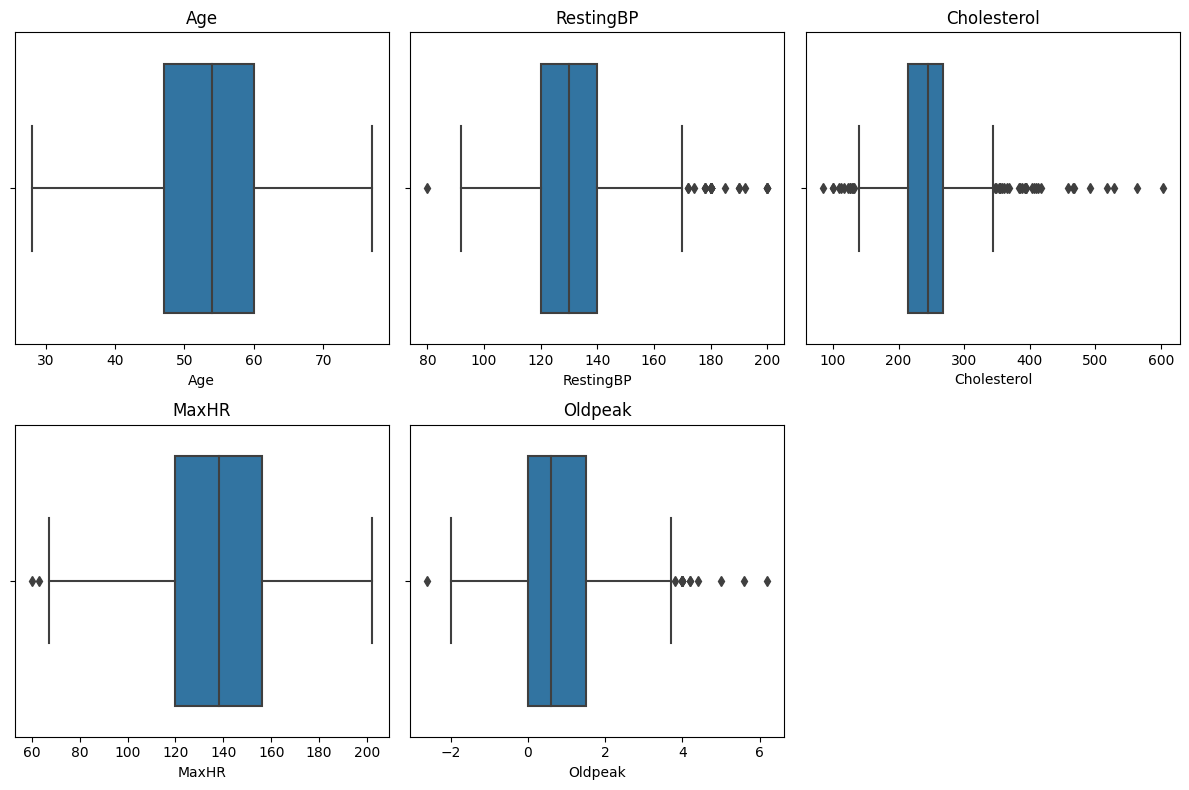

In [63]:
#Inspect for outliers

numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Plot box plots for each numerical column
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


Considering the presence of outliers and the right-skewed 'Oldpeak' feature we can scale the data with a Robust Scaler


In [64]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer


# Define the target variable
y = df['HeartDisease']

# Split the data into features (X) and target variable (y)
X = df.drop('HeartDisease', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numerical and categorical features
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Define the preprocessing pipeline without remainder='passthrough'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder())
        ]), categorical_features)
    ])

# Define the model (Random Forest Classifier)
model = RandomForestClassifier(random_state=42)  # Set random_state for reproducibility

# Create a pipeline by combining the preprocessing steps and the classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='recall')

# Print the cross-validation scores and the mean score
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", np.mean(cv_scores))

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict using the trained pipeline
y_pred_all_features = pipeline.predict(X_test)


Cross-validation scores:  [0.92156863 0.75490196 0.99019608 0.89108911 0.77227723]
Mean cross-validation score:  0.866006600660066


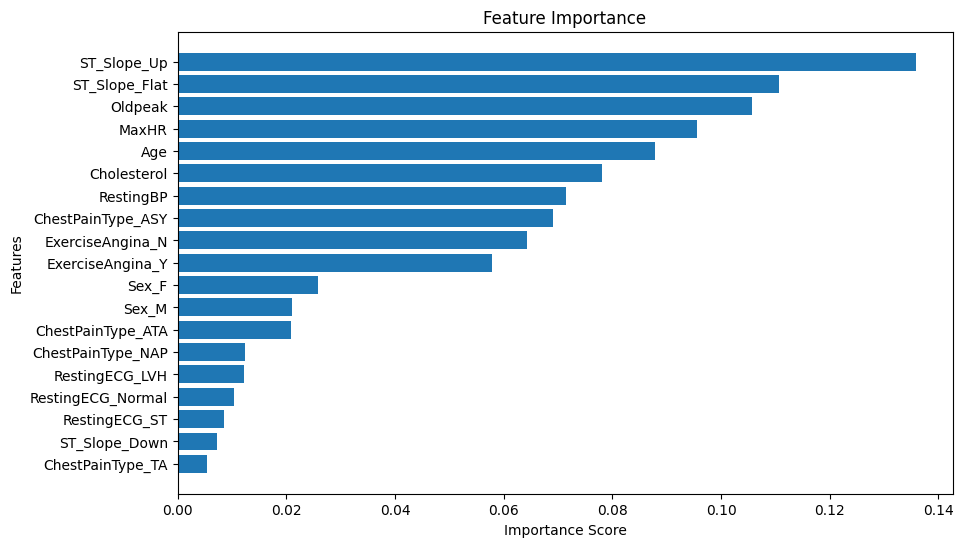

In [65]:
# Extract feature importances
# Get the column names after preprocessing
onehot_columns = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, onehot_columns])

# Ensure the lengths match
assert len(all_feature_names) == len(pipeline.named_steps['classifier'].feature_importances_), "Mismatch between feature names and importances lengths"

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': pipeline.named_steps['classifier'].feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


## Analysis of Feature Importance

**ST_Slope_Up**: This feature has the highest importance score (0.1436), suggesting that it plays a significant role in predicting the presence of Heart Disease. Patients with an upward-sloping ST segment during exercise probably have a higher risk.

**ST_Slope_Flat**: Following closely is the flat ST segment during exercise (Importance Score: 0.1096), which also indicates relevance in predicting Heart Disease.

**Oldpeak**: Oldpeak, or the ST depression induced by exercise relative to rest, ranks third in importance (0.1017). Higher values of Oldpeak are associated with a higher risk of Heart Disease.

**MaxHR**: Maximum Heart Rate achieved during exercise (0.0994) is another crucial feature in predicting Heart Disease. 

**Cholesterol**, **Age**: These features contribute moderately to predicting Heart Disease, with importance scores of 0.0869 and 0.0833, respectively. 

**RestingBP**, **ChestPainType_ASY**: Resting Blood Pressure and Asymptomatic Chest Pain Type have moderate importance scores (0.0747 and 0.0713), suggesting their role in predicting Heart Disease.

**ExerciseAngina_Y**, **ExerciseAngina_N**: Presence or absence of exercise-induced angina (0.0671 and 0.0618) also contributes to predicting Heart Disease, though to a lesser extent compared to other features.

**Sex_M**, **ChestPainType_ATA**, **Sex_F**, **ChestPainType_NAP**: Gender and different types of Chest Pain also have some influence on predicting Heart Disease, but their importance scores are relatively lower.

**ST_Slope_Down**, **ChestPainType_TA**: Features like downward-sloping ST segment and Typical Angina Chest Pain have the lowest importance scores, indicating less influence on predicting Heart Disease compared to others.


### Retention of All Features

In this clinical dataset, we want to retain all features to avoid the loss of critical information. Omitting any potentially important feature could lead to a lack of valuable insights that might be crucial for accurate prediction of heart disease. Each feature, such as age, resting blood pressure, cholesterol levels, and various clinical indicators, offers unique insights into a patient's health status. Removing any feature could result in overlooking important patterns or correlations that could impact the model's predictive performance.

By retaining all features, our model can leverage the full spectrum of clinical information to make informed predictions. This approach ensures that our model is comprehensive and robust, capable of capturing the complexities of cardiovascular health and providing accurate assessments.

### Hyperparameter Tuning

Additionally, we can further enhance our model's performance by performing a grid search to fine-tune the model hyperparameters. This optimization process allows us to systematically explore different combinations of hyperparameters and evaluate their impact on the model's performance. By optimizing the model hyperparameters, we aim to improve the model's predictive accuracy and generalization capabilities, ultimately enhancing its utility in clinical practice.



In [66]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],

}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best estimator
best_estimator = grid_search.best_estimator_

# Cross-validation with best estimator
cv_scores_after_grid_search = cross_val_score(best_estimator, X, y, cv=5, scoring='recall')
print("Cross-validation scores after grid search: ", cv_scores_after_grid_search)
print("Mean cross-validation score after grid search: ", np.mean(cv_scores_after_grid_search))


Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Cross-validation scores after grid search:  [0.94117647 0.7745098  0.99019608 0.9009901  0.77227723]
Mean cross-validation score after grid search:  0.8758299359347699


In [67]:
from sklearn.metrics import classification_report



print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        77
           1       0.88      0.86      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



<!-- Conclusion -->
### Conclusion

The classification report provides a comprehensive summary of the performance of the trained model on the test dataset. Here are the key observations:

- **Precision**: The model achieves a precision of 81% for class 0 and 88% for class 1. This indicates that when the model predicts an instance as positive, it is correct approximately 81% and 88% of the time for classes 0 and 1, respectively.
  
- **Recall**: The recall, or true positive rate, is 84% for class 0 and 86% for class 1. This suggests that the model is able to correctly identify approximately 84% and 86% of the actual positive instances for classes 0 and 1, respectively.

- **F1-Score**: The F1-score, which is the harmonic mean of precision and recall, is 83% for class 0 and 87% for class 1. This metric provides a balance between precision and recall.

- **Accuracy**: The overall accuracy of the model is 85%, indicating the proportion of correctly classified instances out of the total number of instances in the test dataset.

Additionally, from the confusion matrix, it emerges that the model is better at predicting true positives than true negatives, which may be attributed to the slightly imbalanced class distribution. With a larger dataset and potentially more balanced classes, the model is expected to perform even better.

In conclusion, the model demonstrates good performance in classifying instances into the two classes, with high precision, recall, and F1-score values, as well as a satisfactory overall accuracy.
